In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score 

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [23]:
def combine_prob(prob_knn,prob_xgb,y_true):
    """Combine probabilities from XGB and KNN and print Gini scores 
       and correlation of probabilities""" 
    # Correlation of probabilities
    correlation = pearsonr(prob_knn,prob_xgb)[0]
    print('\nCorrelation: {0:.5f}'.format(correlation))
    
    # Compute Gini scores
    gini_knn = roc_auc_score(y_true, prob_knn)*2-1
    print('Knn Gini: {0:.6f}'.format(gini_knn))
    gini_xgb = roc_auc_score(y_true, prob_xgb)*2-1
    print('XGB Gini: {0:.6f}'.format(gini_xgb))
    
    # Determine best k value for train data
    kmax = 0
    scoremax = 0
    for k in range(1,21,1):
        score = roc_auc_score(y_true, prob_knn+k*prob_xgb)*2-1
        if score > scoremax:
            kmax = k
            scoremax = score
    print('Best Gini: {0:.6f} for k = {1:d}'.format(scoremax, kmax))
    
    # Compute k-value to use for test data and produce combined probabilities and score
    auto_k=200*(gini_xgb-gini_knn)/(gini_xgb+gini_knn)
    combined_probs = prob_knn+k*prob_xgb
    combined_score = 2* roc_auc_score(y_true, prob_knn + auto_k*prob_xgb) - 1
    print('Auto Gini: {0:.6f} for k = {1:.2f}'.format(combined_score,auto_k))
    
    return correlation, gini_knn, kmax, auto_k, combined_probs, combined_score 

In [3]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.gini_train_ = []
        self.gini_test_ = []
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_proba(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc * 2 ) - 1
        self.gini_train_.append(roc*2-1)
    
        y_pred_val = self.model.predict_proba(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_val * 2 ) - 1
        self.gini_test_.append(roc_val*2-1)
        
        print('\nnorm_gini: {0:.5f} - norm_gini_val: {1:.5f}\n'.format((roc*2-1), (roc_val*2-1)))
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [4]:
# Load train and test data
data_train = pd.read_csv('train/train.csv')
data_test = pd.read_csv('test/test.csv')

In [5]:
# Reduce memory usage
float_col = [col for col in data_train.columns if data_train[col].dtypes == 'float64']
int_col = [col for col in data_train.columns if col not in float_col]
# Handle 'id' and 'target' columns separately
int_col = int_col[2:]
data_train['target'] = data_train['target'].astype(np.int32)

for col in float_col:
    data_train[col] = data_train[col].astype(np.float32)
    data_test[col] = data_test[col].astype(np.float32)

for col in int_col:
    data_train[col] = data_train[col].astype(np.int32)
    data_test[col] = data_test[col].astype(np.int32)

In [6]:
# Eliminate id and target columns for training and submission data
X = data_train.iloc[:,2:]
sub_df = data_test.iloc[:,1:]

# Set y as target values
y = data_train['target']

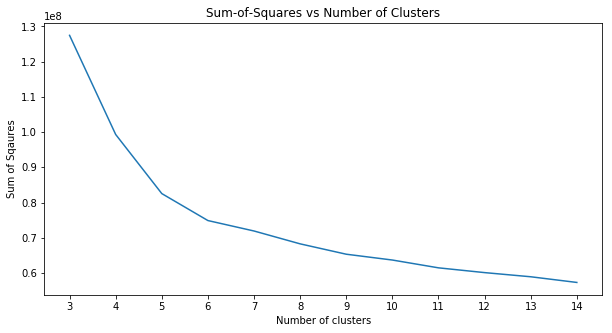

In [7]:
# Determine best clustering of points to use as feature
clusters=range(3,15)
# clusters = [5,8,11,14]
# Save KMeans results in list
k_means_vars = [KMeans(n_clusters=k, random_state=2017).fit(X) for k in clusters]

# List of Sum of Squares depending on n_clusters
SS = [x.inertia_ for x in k_means_vars]

# plotting SS values versus the number of clusters used 
plt.figure(figsize=(10,5))
plt.plot(clusters,SS)
plt.xticks(clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaures')
plt.title('Sum-of-Squares vs Number of Clusters')
plt.show()

In [8]:
# Add 'best' clusterings
clusters_list = ['05','08'] #,'11','14']

# Create temporary list of clustering results
tmp_X = []
tmp_sub_df = []
for i,clstr in enumerate(clusters_list):
    tmp_X.append(k_means_vars[i].predict(X))
    tmp_sub_df.append(k_means_vars[i].predict(sub_df))

# Assign clusters' labels to X and sub_df DFs 
for i,clstr in enumerate(clusters_list):
    X['cluster_'+clstr+'_cat'] = tmp_X[i]
    sub_df['cluster_'+clstr+'_cat'] = tmp_sub_df[i]

# Delete temporary lists
del tmp_X
del tmp_sub_df

In [9]:
# Create list of categorical, binary, and 'calc' variables
cat_cols = [n for n in X.columns if 'cat'  in n] 
bin_cols = [n for n in X.columns if 'bin'  in n] 
# num_cols = [n for n in X.columns if n not in cat_cols and n not in bin_cols]
calc_cols = [n for n in X.columns if 'calc' in n]

# Set categorical columns as type 'category'
for col in cat_cols:
    X[col] = X[col].astype('category')
    sub_df[col] = sub_df[col].astype('category')

# Eliminate 'calc' columns
for col in calc_cols:
    del X[col]
    del sub_df[col]

# Convert categorical columns to binary
X = pd.get_dummies(X) #, drop_first=True)
sub_df = pd.get_dummies(sub_df) #, drop_first=True)

In [10]:
# # Create new list of ind features
# ind_bin_cols = [n for n in X.columns if ('ind'  in n) and ('bin' in n)] 

# # Create temporary DFs for sum and distance features of binary 'ind' features
# tmp_X = X.loc[:,ind_bin_cols]
# tmp_sub_df = sub_df.loc[:,ind_bin_cols]

# # Define sum as number of ones in such columns
# X['ind_sum'] = tmp_X.sum(axis=1) 
# sub_df['ind_sum'] = tmp_sub_df.sum(axis=1) 

# # Define distance as sum of absolute differences with median of feature
# X['ind_dist'] = (tmp_X-tmp_X.median(axis=0).values.squeeze()).sum(axis=1)
# sub_df['ind_dist'] = (tmp_sub_df-tmp_sub_df.median(axis=0).values.squeeze()).sum(axis=1)

# # Eliminate temporary DFs
# del tmp_X
# del tmp_sub_df

# # Eliminate extremely unbalanced binary features
# unbalanced = ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']
# for col in unbalanced:
#     del X[col]
#     del sub_df[col]

In [10]:
# Apply train test split on training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=840)
print(y_train.mean())
print(y_test.mean())

0.0366508529535
0.0356341826063


In [11]:
# Set optimal parameters for XGBoost
params_xgb = {'n_estimators' : 177,
              'max_depth' : 5, 
              'base_score' : 0.3,
              'learning_rate' : 0.07, 
              'min_child_weight' : 6,
              'scale_pos_weight' : 1.2,
              'gamma' : 10,
              'reg_alpha' : 8,
              'reg_lambda' : 1.3,
              'objective' : 'binary:logistic',
              'nthread' : -1,
              'missing' : -1,
              'subsample' : .8,
              'colsample_bytree' : .8,
              'seed' : 84
            }

In [12]:
clf = xgb.XGBClassifier(**params_xgb)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.596638	validation_1-auc:0.595668
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.602719	validation_1-auc:0.600395
[2]	validation_0-auc:0.604251	validation_1-auc:0.601532
[3]	validation_0-auc:0.606105	validation_1-auc:0.602647
[4]	validation_0-auc:0.607378	validation_1-auc:0.604361
[5]	validation_0-auc:0.608494	validation_1-auc:0.604888
[6]	validation_0-auc:0.609751	validation_1-auc:0.605965
[7]	validation_0-auc:0.609207	validation_1-auc:0.605928
[8]	validation_0-auc:0.609323	validation_1-auc:0.605951
[9]	validation_0-auc:0.610657	validation_1-auc:0.607737
[10]	validation_0-auc:0.610551	validation_1-auc:0.607824
[11]	validation_0-auc:0.611927	validation_1-auc:0.608648
[12]	validation_0-auc:0.613289	validation_1-auc:0.610366
[13]	validation_0-auc:0.615308	validation_1-auc:0.611953
[14]	validation_0-auc:0.616214	validation_1-auc:0.61288

[142]	validation_0-auc:0.653995	validation_1-auc:0.641373
[143]	validation_0-auc:0.654053	validation_1-auc:0.641382
[144]	validation_0-auc:0.654119	validation_1-auc:0.641405
[145]	validation_0-auc:0.654119	validation_1-auc:0.641405
[146]	validation_0-auc:0.654121	validation_1-auc:0.641434
[147]	validation_0-auc:0.654201	validation_1-auc:0.64152
[148]	validation_0-auc:0.654248	validation_1-auc:0.64155
[149]	validation_0-auc:0.654267	validation_1-auc:0.641522
[150]	validation_0-auc:0.654267	validation_1-auc:0.641522
[151]	validation_0-auc:0.654316	validation_1-auc:0.641514
[152]	validation_0-auc:0.654316	validation_1-auc:0.641514
[153]	validation_0-auc:0.654355	validation_1-auc:0.641548
[154]	validation_0-auc:0.654464	validation_1-auc:0.641641
[155]	validation_0-auc:0.654464	validation_1-auc:0.641641
[156]	validation_0-auc:0.654592	validation_1-auc:0.641711
[157]	validation_0-auc:0.654601	validation_1-auc:0.641725
[158]	validation_0-auc:0.654601	validation_1-auc:0.641725
[159]	validation

XGBClassifier(base_score=0.3, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=10, learning_rate=0.07, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=-1, n_estimators=177, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1.3,
       scale_pos_weight=1.2, seed=84, silent=True, subsample=0.8)

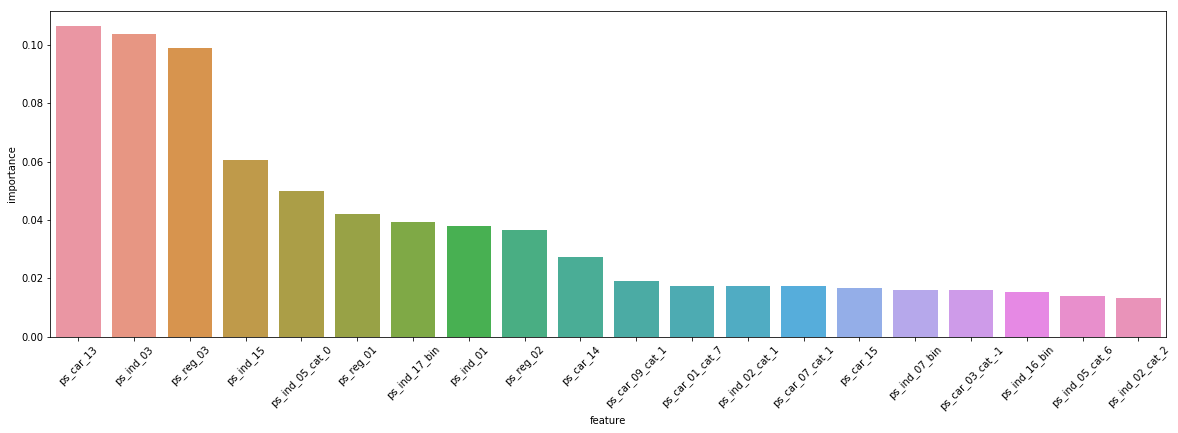

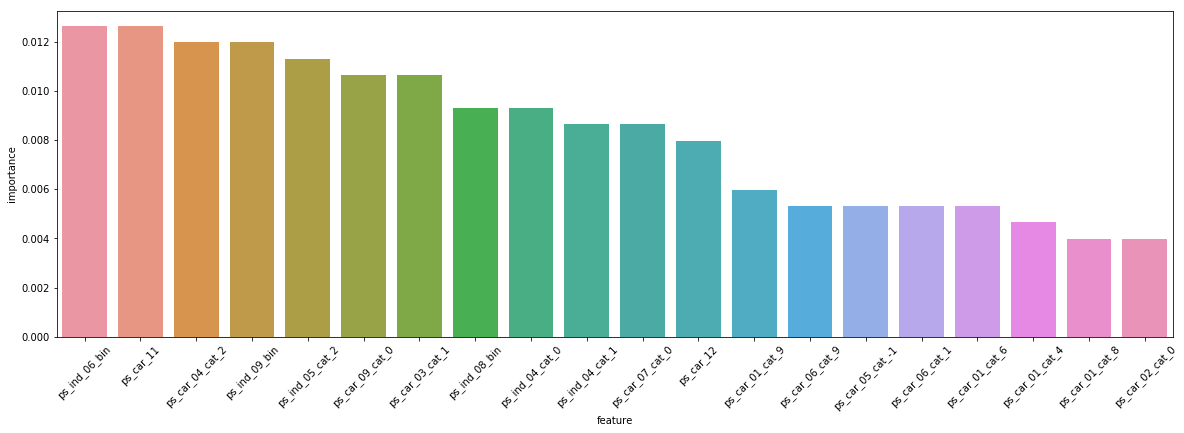

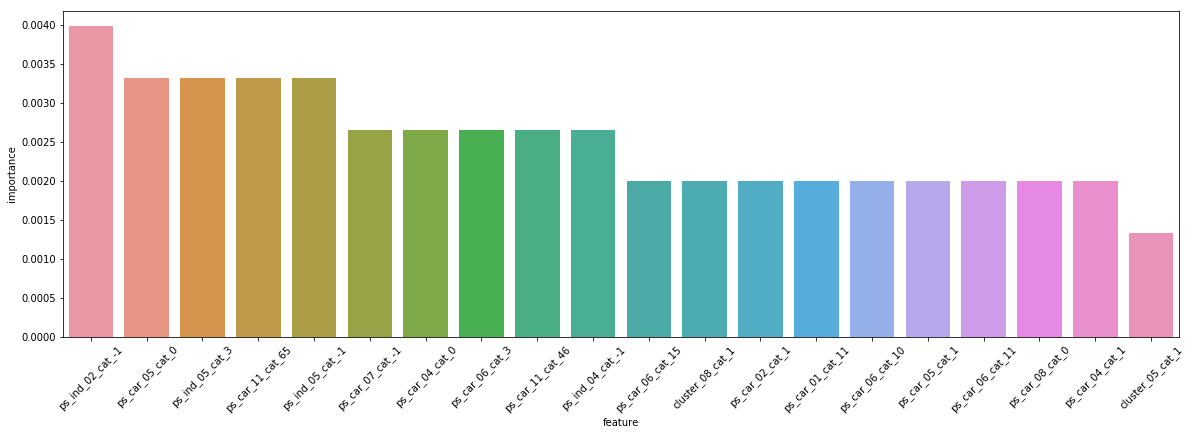

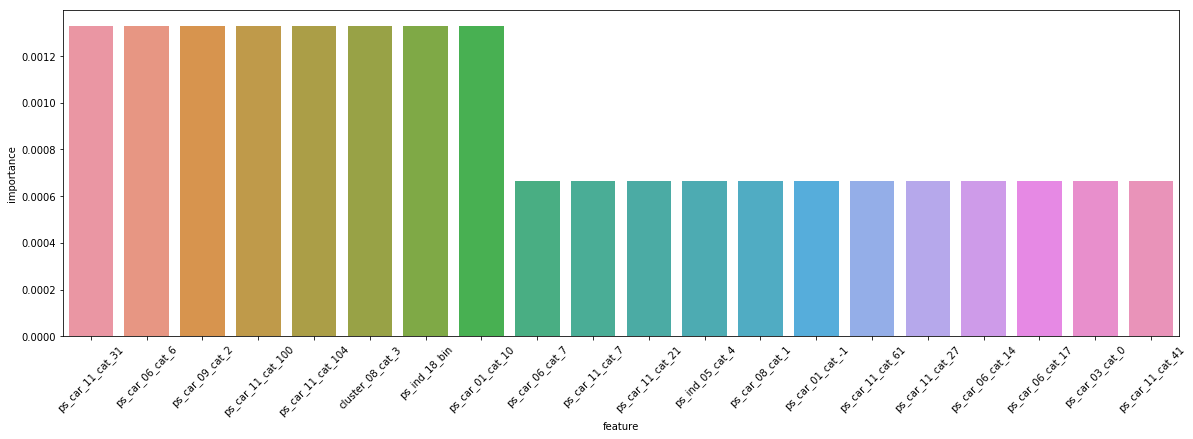

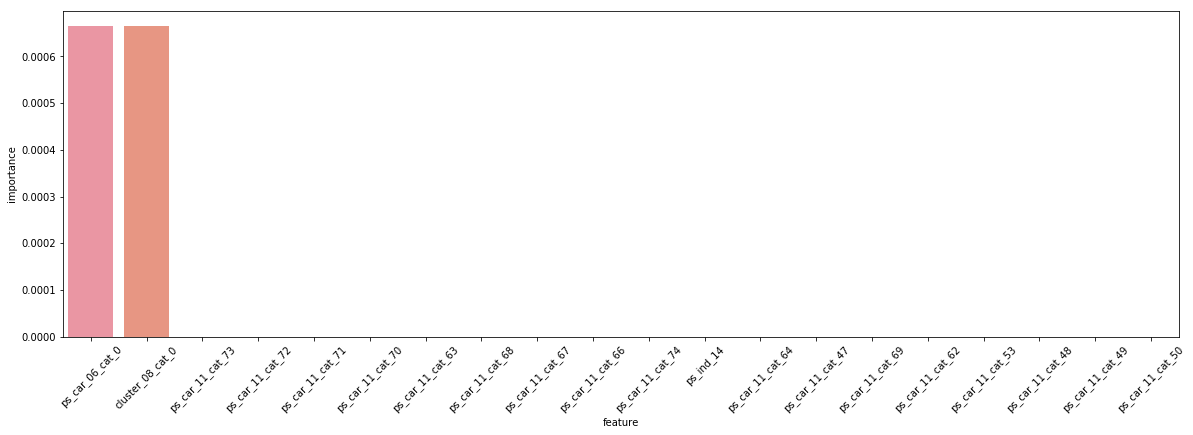

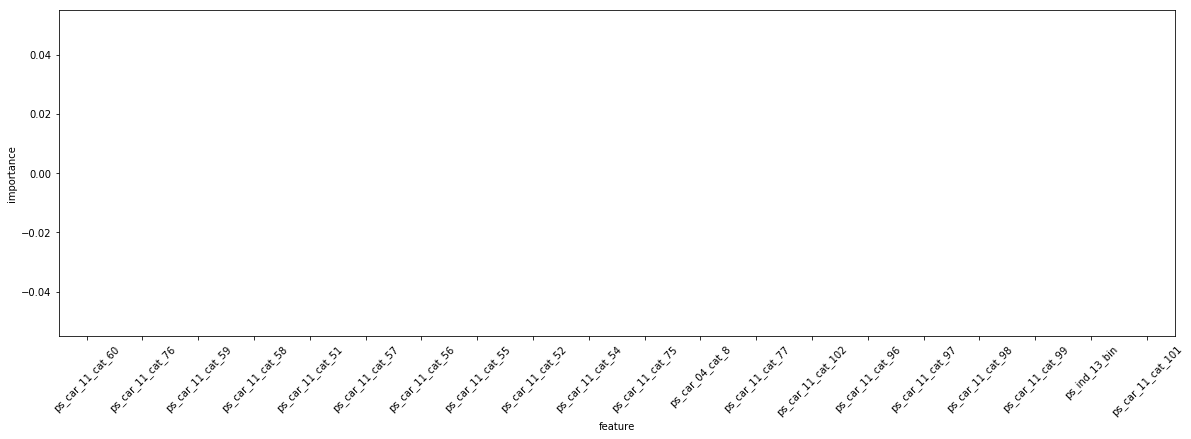

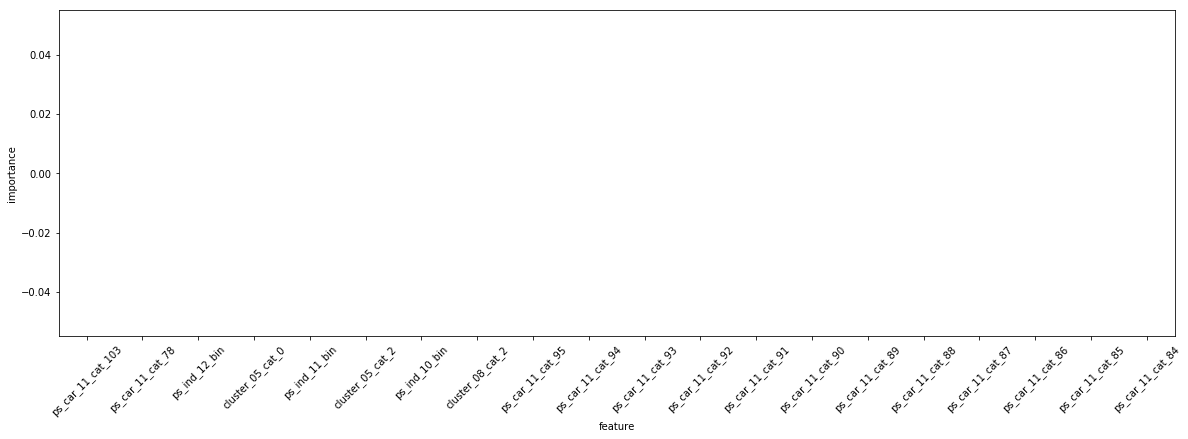

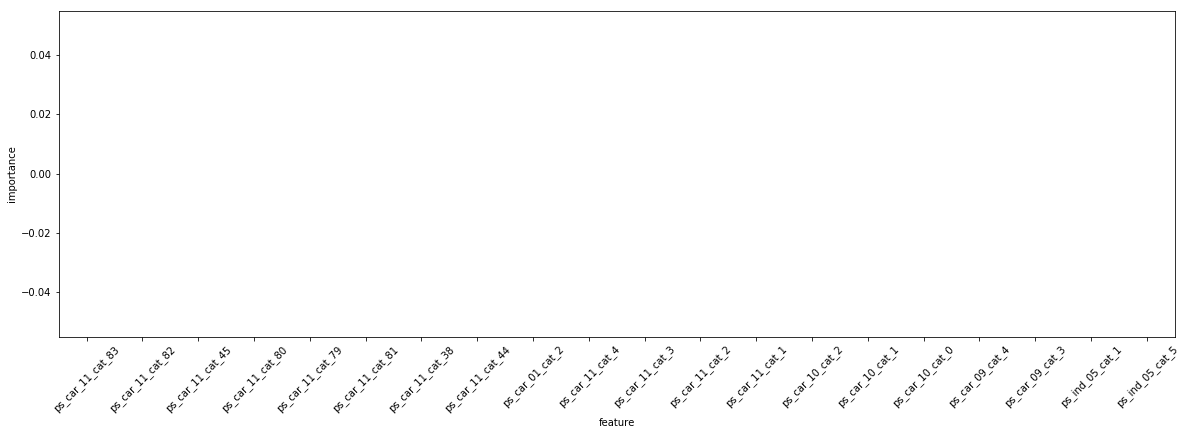

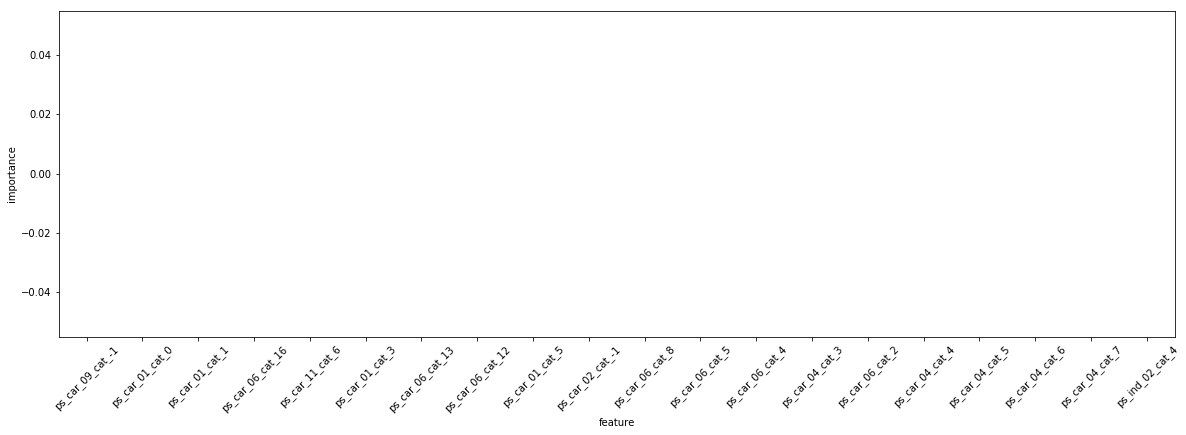

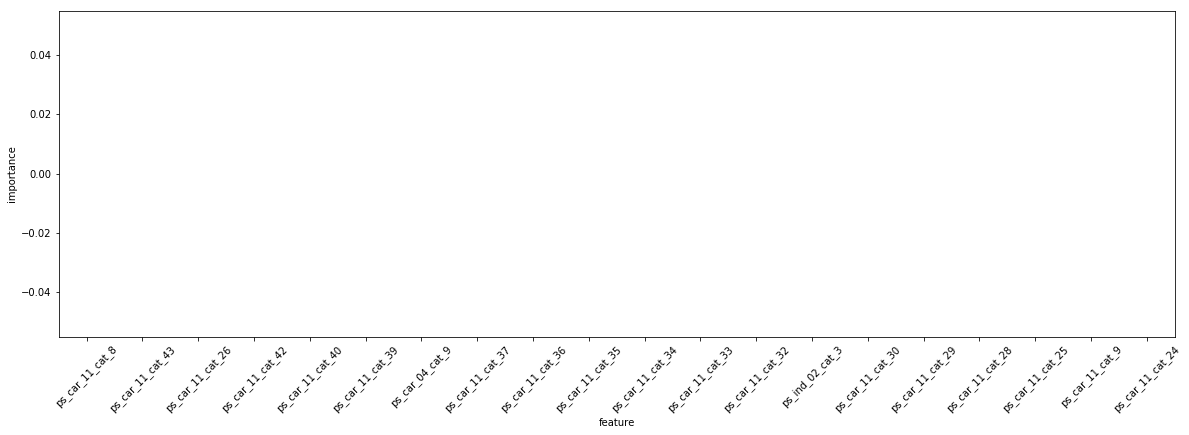

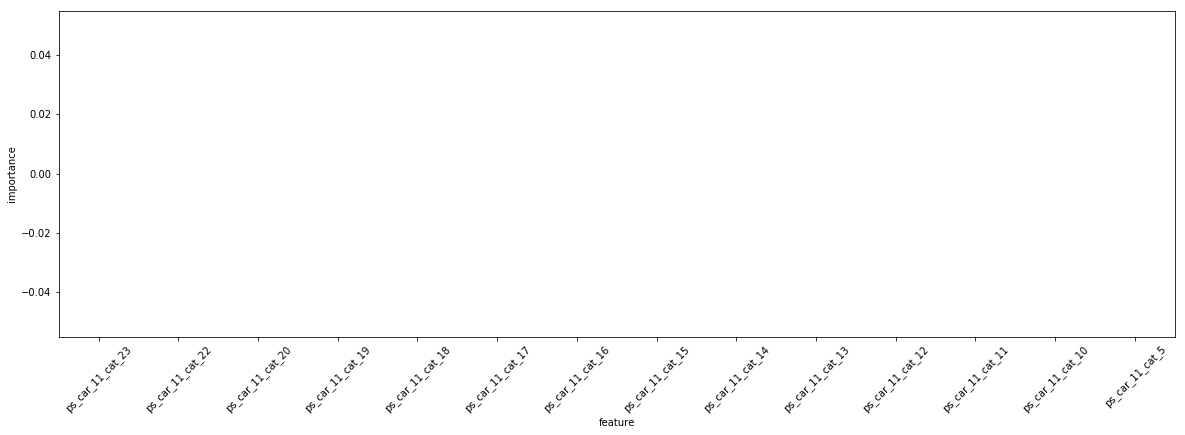

In [13]:
df = pd.DataFrame({'feature':X_train.columns, 'importance': clf.feature_importances_})
df = df.sort_values('importance', ascending=False)
df.reset_index(drop=True, inplace=True)
for first in range(0, df.shape[0],20):
    last = min(first+20,df.shape[0])
    plotdf = df[first:last]
    plt.figure(figsize=(20,6))
    sns.barplot( 'feature', 'importance', data=plotdf)
    plt.xticks(rotation=45)
    plt.show()

In [14]:
df.head(10)

,feature,importance
0,ps_car_13,0.106383
1,ps_ind_03,0.103723
2,ps_reg_03,0.099069
3,ps_ind_15,0.060505
4,ps_ind_05_cat_0,0.049867
5,ps_reg_01,0.041888
6,ps_ind_17_bin,0.039229
7,ps_ind_01,0.037899
8,ps_reg_02,0.036569
9,ps_car_14,0.027261


In [16]:
# Add XGB result to train, test, and submission dataframes for KNN run
X_train['xgb'] = clf.predict_proba(X_train)[:,1]
X_test['xgb'] = clf.predict_proba(X_test)[:,1]
sub_df['xgb'] = clf.predict_proba(sub_df)[:,1]

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Save to file XGBoost results 
ids = data_test['id']
target = sub_df['xgb']
submission_df = pd.DataFrame({'id': ids, 'target':target})

# Save to file for later submission
submission_df.to_csv('XGB_OPTIMAL.csv', index=False)

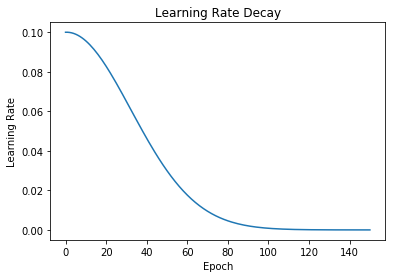

In [18]:
lr = [.1]
decay = .001
epochs = range(150)
for epoch in epochs:
    lr.append(lr[epoch]* 1/(1 + decay * epoch))
plt.plot(lr)
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.title('Learning Rate Decay')
plt.show()

In [19]:
# EarlyStopping and Gini calculator callbacks function for KNN
escb = EarlyStopping(monitor='norm_gini_val', patience=3, mode='max', verbose=1)
roccb = roc_auc_callback(training_data=(np.array(X_train), y_train), validation_data=(np.array(X_test), y_test)) 

# Set up filepath to store best result
filepath = 'weights.best.after.hdf5'
mcpcb = ModelCheckpoint(filepath, monitor='norm_gini_val', mode='max', save_best_only=True, verbose=1)

# Create Keras Sequential Neural Network (one hidden layer)
model = Sequential()
model.add(Dense(3000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(800, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(800, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.1, decay=.001, momentum=0.85, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy')
# Fit model using 'batch' batches
model.fit( np.array(X_train), y_train,
          validation_data=(np.array(X_test), y_test),
          batch_size=128,
          epochs=150,
          verbose=1,
#           shuffle=True,
          callbacks=[roccb, mcpcb, escb]
         )

# Recreate best KNN model (due to EarlyStopping)
model = Sequential()
model.add(Dense(3000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(800, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(800, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
model.load_weights(filepath)
model.compile(optimizer=sgd, loss='binary_crossentropy')

Train on 476169 samples, validate on 119043 samples
Epoch 1/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1619
norm_gini: 0.25250 - norm_gini_val: 0.24950

Epoch 00000: norm_gini_val improved from -inf to 0.24950, saving model to weights.best.after.hdf5
476169/476169 [==============================] - 823s - loss: 0.1619 - val_loss: 0.1511
Epoch 2/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1543
norm_gini: 0.26495 - norm_gini_val: 0.26060

Epoch 00001: norm_gini_val improved from 0.24950 to 0.26060, saving model to weights.best.after.hdf5
476169/476169 [==============================] - 830s - loss: 0.1543 - val_loss: 0.1501
Epoch 3/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1538
norm_gini: 0.26988 - norm_gini_val: 0.26463

Epoch 00002: norm_gini_val improved from 0.26060 to 0.26463, saving model to weights.best.after.hdf5
476169/476169 [==============================] - 828s - loss: 0.1538 - val_loss: 0.15

476169/476169 [==============================] - 800s - loss: 0.1526 - val_loss: 0.1498
Epoch 28/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1526
norm_gini: 0.29415 - norm_gini_val: 0.27733

Epoch 00027: norm_gini_val did not improve
476169/476169 [==============================] - 814s - loss: 0.1526 - val_loss: 0.1500
Epoch 29/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1525
norm_gini: 0.29395 - norm_gini_val: 0.27769

Epoch 00028: norm_gini_val did not improve
476169/476169 [==============================] - 814s - loss: 0.1525 - val_loss: 0.1498
Epoch 30/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1526
norm_gini: 0.29492 - norm_gini_val: 0.27760

Epoch 00029: norm_gini_val did not improve
476169/476169 [==============================] - 814s - loss: 0.1526 - val_loss: 0.1499
Epoch 31/150
476160/476169 [============================>.] - ETA: 0s - loss: 0.1525
norm_gini: 0.29493 - norm_gini_val: 0.27802


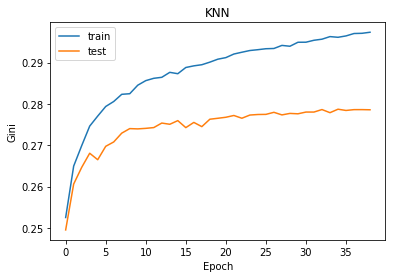

In [20]:
plt.plot(roccb.gini_train_, label='train')
plt.plot(roccb.gini_test_, label='test')
plt.ylabel('Gini')
plt.xlabel('Epoch')
plt.legend()
plt.title('KNN')
plt.show()

In [21]:
# Prepare DataFrame for submission of KNN only
ids = data_test['id']
submission_df = pd.DataFrame({'id': ids, 'target':np.reshape(model.predict_proba(np.array(sub_df)),(-1,))})

# Save to file for submission
submission_df.to_csv('KNN_3000_800.csv', index=False)

892800/892816 [============================>.] - ETA: 0s

In [24]:
# Combine XGB and KNN probabilities, determine best k-value
correlation, gini_knn, best_k, auto_k, combined_probs, combined_score = \
          combine_prob(np.reshape(model.predict_proba(np.array(X_test)),(-1,)), X_test['xgb'], y_test)

119008/119043 [============================>.] - ETA: 0s
Correlation: 0.92689
Knn Gini: 0.278711
XGB Gini: 0.284161
Best Gini: 0.285428 for k = 2
Auto Gini: 0.285424 for k = 1.94


In [25]:
# Prepare DataFrame for submission
ids = data_test['id']
# Combined prediction is average of two predictions
target = (np.reshape(model.predict_proba(np.array(sub_df)),(-1,)) + best_k * sub_df['xgb'])/2
submission_df = pd.DataFrame({'id': ids, 'target':target})

# Save to file for submission
submission_df.to_csv('After_combined.csv', index=False)

892704/892816 [============================>.] - ETA: 0s